In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_06 import *

# ConvNet

In [3]:
x_train, y_train, x_valid, y_valid = get_data()

In [4]:
x_train.mean(), x_train.std()

(tensor(-9.9649e-10), tensor(1.0000))

In [5]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [6]:
nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

In [7]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [8]:
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder,
        CudaCallback,
       partial(AvgStatsCallback, accuracy),
       partial(BatchTransformXCallback, mnist_view)]

In [9]:
nfs = [8, 16, 32, 64, 64]

In [10]:
learn, run = get_learn_run(nfs, data, 0.5, conv_layer, cbs=cbfs)

In [11]:
%time run.fit(2, learn)

train: [1.685701171875, tensor(0.4255, device='cuda:0')]
valid: [0.3336955078125, tensor(0.9059, device='cuda:0')]
train: [0.21782044270833334, tensor(0.9336, device='cuda:0')]
valid: [0.1924189697265625, tensor(0.9425, device='cuda:0')]
CPU times: user 3.01 s, sys: 414 ms, total: 3.43 s
Wall time: 3.11 s


In [12]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones(nf, 1, 1))
        self.adds = nn.Parameter(torch.zeros(nf, 1, 1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))
        self.register_buffer('vars', torch.ones(1,nf,1,1))
        
    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_(v, self.mom)
        return m, v
    
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m, v = self.means, self.vars
        x = (x - m) / (v + self.eps).sqrt()
        return x * self.mults + self.adds

In [13]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, stride, padding=ks//2, bias=not bn),
             GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [14]:
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr, cbs, opt_func)

In [15]:
def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)

In [16]:
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)

In [17]:
learn, run = get_learn_run(nfs, data, 0.9, conv_layer, cbfs)

In [18]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm()
  )
  (4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm()
  )
  (5): AdaptiveAvgPool2d(output_size=1)
  (6): Lambda()
  (7): Linear(in_features=64, out_features=10, bias=True)
)

train: [0.25341741536458334, tensor(0.9205, device='cuda:0')]
valid: [1.27089677734375, tensor(0.7522, device='cuda:0')]


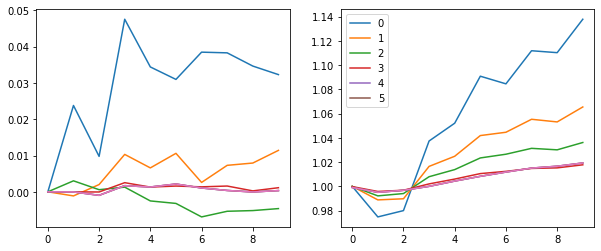

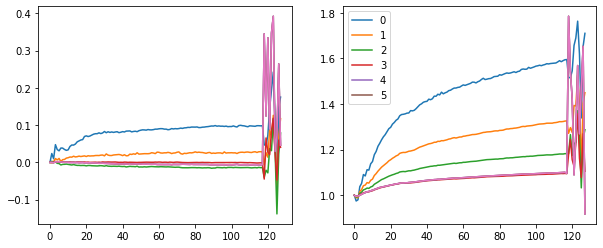

In [19]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4))
    for h in hooks[:-1]:
        ms, ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4))
    for h in hooks[:-1]:
        ms, ss, = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6))

In [20]:
learn, run = get_learn_run(nfs, data, 1.0, conv_layer, cbfs)

In [21]:
%time run.fit(3, learn)

train: [0.25737146809895833, tensor(0.9184, device='cuda:0')]
valid: [0.326709033203125, tensor(0.8979, device='cuda:0')]
train: [0.085421044921875, tensor(0.9735, device='cuda:0')]
valid: [1.6419958984375, tensor(0.7172, device='cuda:0')]
train: [0.06695880940755208, tensor(0.9790, device='cuda:0')]
valid: [0.3725468994140625, tensor(0.9093, device='cuda:0')]
CPU times: user 4.8 s, sys: 612 ms, total: 5.41 s
Wall time: 4.83 s


In [22]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, stride, padding=ks//2, bias=not bn),
             GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

In [23]:
learn, run = get_learn_run(nfs, data, 1., conv_layer, cbfs)

In [24]:
%time run.fit(3, learn)

train: [0.187758935546875, tensor(0.9416, device='cuda:0')]
valid: [0.13008226318359375, tensor(0.9565, device='cuda:0')]
train: [0.05738068033854166, tensor(0.9824, device='cuda:0')]
valid: [0.3450939208984375, tensor(0.9018, device='cuda:0')]
train: [0.042278706868489585, tensor(0.9870, device='cuda:0')]
valid: [0.04936371765136719, tensor(0.9830, device='cuda:0')]
CPU times: user 4.37 s, sys: 481 ms, total: 4.85 s
Wall time: 4.28 s


In [25]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)]) 

In [26]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched)])

In [27]:
run.fit(8, learn)

train: [0.22480997721354168, tensor(0.9318, device='cuda:0')]
valid: [0.41977919921875, tensor(0.8962, device='cuda:0')]
train: [0.0772532470703125, tensor(0.9758, device='cuda:0')]
valid: [0.1775421142578125, tensor(0.9404, device='cuda:0')]
train: [0.053584033203125, tensor(0.9834, device='cuda:0')]
valid: [0.0870523681640625, tensor(0.9735, device='cuda:0')]
train: [0.036503889973958335, tensor(0.9885, device='cuda:0')]
valid: [0.105849951171875, tensor(0.9664, device='cuda:0')]
train: [0.02241475626627604, tensor(0.9930, device='cuda:0')]
valid: [0.04261329650878906, tensor(0.9869, device='cuda:0')]
train: [0.01331281229654948, tensor(0.9961, device='cuda:0')]
valid: [0.03205689697265625, tensor(0.9903, device='cuda:0')]
train: [0.007658238220214844, tensor(0.9982, device='cuda:0')]
valid: [0.031089163208007812, tensor(0.9907, device='cuda:0')]
train: [0.005093191528320312, tensor(0.9992, device='cuda:0')]
valid: [0.03163285217285156, tensor(0.9907, device='cuda:0')]


# More norms

## Layer norms

In [28]:
class LayerNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add = nn.Parameter(tensor(0.))
        
    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.var((1,2,3), keepdim=True)
        x = (x - m) / (v + self.eps).sqrt()
        return x * self.mult + self.add

In [29]:
def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, stride, padding=ks//2, bias=True),
             GeneralRelu(**kwargs)]
    if bn: layers.append(LayerNorm())
    return nn.Sequential(*layers)

In [30]:
learn, run = get_learn_run(nfs, data, 0.8, conv_ln, cbfs)

In [31]:
%time run.fit(3, learn)

train: [0.3239337239583333, tensor(0.8952, device='cuda:0')]
valid: [0.2911647216796875, tensor(0.9168, device='cuda:0')]
train: [0.0859021240234375, tensor(0.9743, device='cuda:0')]
valid: [0.89198486328125, tensor(0.7950, device='cuda:0')]
train: [nan, tensor(0.1119, device='cuda:0')]
valid: [nan, tensor(0.0980, device='cuda:0')]
CPU times: user 5.45 s, sys: 611 ms, total: 6.06 s
Wall time: 5.49 s


# Instance Norm

In [32]:
class InstanceNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, nf, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(torch.ones(nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        
    def forward(self, x):
        m = x.mean((2,3), keepdim=True)
        v = x.var((2,3), keepdim=True)
        x = (x - m) / (v + self.eps).sqrt()
        return x * self.mult + self.adds

In [33]:
def conv_in(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, stride, padding=ks//2, bias=True),
             GeneralRelu(**kwargs)]
    if bn: layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)

In [34]:
learn, run = get_learn_run(nfs, data, 0.1, conv_in, cbfs)

In [35]:
run.fit(3, learn)

train: [nan, tensor(0.0987, device='cuda:0')]
valid: [nan, tensor(0.0980, device='cuda:0')]
train: [nan, tensor(0.0987, device='cuda:0')]
valid: [nan, tensor(0.0980, device='cuda:0')]
train: [nan, tensor(0.0987, device='cuda:0')]
valid: [nan, tensor(0.0980, device='cuda:0')]


# Fix small batch sizes

In [36]:
data = DataBunch(*get_dls(train_ds, valid_ds, 2), c)

In [37]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [38]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [39]:
%time run.fit(1, learn)

train: [2.3142338541666665, tensor(0.2034, device='cuda:0')]
valid: [2.70198046875, tensor(0.3043, device='cuda:0')]
CPU times: user 1min 57s, sys: 7.7 s, total: 2min 5s
Wall time: 2min 3s


In [40]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones(nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('step', tensor(0.))
        self.register_buffer('dbias', tensor(0.))
     
    def update_stats(self, x):
        bs, nc, *_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        
        c = self.count.new_tensor(x.numel() / nc)
        mom1 = 1 - (1 - self.mom) / math.sqrt(bs-1)
        self.mom1 = self.dbias.new_tensor(mom1)
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        self.dbias = self.dbias * (1 - self.mom1) + self.mom1
        self.batch += bs
        self.step += 1
    
    def forward(self, x):
        if self.training: self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        c = self.count
        if self.step < 100:
            sums = sums / self.dbias
            sqrs = sqrs / self.dbias
            c = c / self.dbias
        means = sums / c
        vars = (sqrs/c).sub_(means*means)
        
        if bool(self.batch < 20): vars.clamp_min_(0.01)
        x = (x - means).div_((vars.add_(self.eps)).sqrt())
        return x.mul_(self.mults).add_(self.adds)

In [41]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

In [42]:
learn,run = get_learn_run(nfs, data, 0.4, conv_rbn, cbs=cbfs)

In [47]:
# %time run.fit(1, learn)

train: [0.0727573486328125, tensor(0.9779, device='cuda:0')]
valid: [0.06589075317382813, tensor(0.9816, device='cuda:0')]
CPU times: user 27 s, sys: 3.18 s, total: 30.2 s
Wall time: 29.9 s


In [53]:
data = DataBunch(*get_dls(train_ds, valid_ds, 32), c)

In [54]:
learn,run = get_learn_run(nfs, data, 0.9, conv_rbn, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched_lin(1., 0.2))])

In [55]:
%time run.fit(1, learn)

train: [0.14121311848958334, tensor(0.9564, device='cuda:0')]
valid: [0.053245751953125, tensor(0.9842, device='cuda:0')]
CPU times: user 19.4 s, sys: 2.26 s, total: 21.7 s
Wall time: 21.4 s


In [81]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones(nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        self.register_buffer('count', tensor(0.))
#         self.register_buffer('step', tensor(0.))
#         self.register_buffer('dbias', tensor(0.))
#         self.register_buffer('batch', tensor(0.))
        self.batch = 0
        self.register_buffer('factor', tensor(0.))
        self.register_buffer('offset', tensor(0.))
     
    def update_stats(self, x):
        bs, nc, *_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
#         c = self.count.new_tensor(x.numel() / nc)
        c = s.new_tensor(x.numel() / nc)
    
#         mom1 = 1 - (1 - self.mom) / math.sqrt(bs-1)
        mom1 = s.new_tensor(1 - (1-self.mom) / math.sqrt(bs-1))
#         self.mom1 = self.dbias.new_tensor(mom1)
        self.sums.lerp_(s, mom1)
        self.sqrs.lerp_(ss, mom1)
        self.count.lerp_(c, mom1)
#         self.dbias = self.dbias * (1 - self.mom1) + self.mom1
        self.batch += bs
#         self.step += 1
        means = self.sums / self.count
        varns = (self.sqrs / self.count).sub_(means*means)
        if bool(self.batch < 20): varns.clamp_min_(0.01) 
        self.factor = self.mults / (varns + self.eps).sqrt()
        self.offset = self.adds - means * self.factor
    
    def forward(self, x):
        if self.training: self.update_stats(x)
        return x * self.factor + self.offset

In [82]:
learn,run = get_learn_run(nfs, data, 0.9, conv_rbn, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched_lin(1., 0.2))])

In [83]:
%time run.fit(1, learn)

{'self': RunningBatchNorm(), 'x': tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[1.0580e-01, 1.3786e-01, 1.3786e-01,  ..., 1.3786e-01,
           1.3786e-01, 4.6080e-01],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 2.4166e-01],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 2.4166e-01],
          ...,
          [0.0000e+00, 0.